In [1]:
%matplotlib inline
# Dependencies
import pandas as pd
import numpy as np
import time
import datetime
from pandas import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr

# Part I - Data Prep
This part creates 2 dataframes:
* The first data frame (analysis_data) has historical information for all stores opened since Jan'18 (total of 18 stores). This will be used for analysis on historical trends
* The second data frame (p2_analysis_data) has store level information for all 25, and will be used to combine internal with external information (Yelp and Census)

In [2]:
# Import the source files - first with historical daily counts for each store and second with the binning defined by business expert
store_counts_original = pd.read_csv("../Resources/Counts_labeledbetter.csv")
store_bins = pd.read_csv("../Resources/bins.csv")
store_counts_original.describe()

,StoreID,DF_Month,numericalDay,Day,Year,CouponsRedeemed,DiscountsApplied,HouseComps,BadService,TotCustbyDay,NewCust,DeliveryCount,PickupCount,WalkinCount,DineinCount,Dinein_2Count,WalkthroughWL,GrubhubDeliveryCt,GrubhubPUorBeer
count,54441.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000
mean,10862.413567,6.392825,4.004735,15.699701,2015.045120,53.596330,8.098535,2.157980,0.624798,258.210626,20.275312,58.139548,76.381859,79.437905,30.768574,0.831519,11.193610,0.377812,1.129148
std,3512.534086,3.390973,1.999863,8.769738,2.028715,50.286335,7.532006,2.639356,0.953211,162.850715,17.289787,48.720466,58.305628,63.090870,32.706801,2.715224,55.785002,1.714351,5.631766
min,122.000000,1.000000,1.000000,1.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10688.000000,3.000000,2.000000,8.000000,2014.000000,16.000000,3.000000,0.000000,0.000000,143.000000,8.000000,25.000000,36.000000,21.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,11834.000000,6.000000,4.000000,16.000000,2015.000000,40.000000,6.000000,1.000000,0.000000,227.000000,17.000000,46.000000,60.000000,68.000000,22.000000,0.000000,0.000000,0.000000,0.000000
75%,12359.000000,9.000000,6.000000,23.000000,2017.000000,77.000000,11.000000,3.000000,1.000000,340.000000,28.000000,78.000000,101.000000,126.000000,47.000000,0.000000,0.000000,0.000000,0.000000
max,78945.000000,12.000000,7.000000,31.000000,2018.000000,1030.000000,274.000000,55.000000,9.000000,1185.000000,285.000000,415.000000,516.000000,869.000000,687.000000,38.000000,541.000000,36.000000,361.000000


In [3]:
# Clean up the original counts data, removing all record with missings
store_counts_cleanup = store_counts_original.dropna().astype(int)
store_counts_cleanup.describe()
# store_counts_cleanup.dtypes

,StoreID,DF_Month,numericalDay,Day,Year,CouponsRedeemed,DiscountsApplied,HouseComps,BadService,TotCustbyDay,NewCust,DeliveryCount,PickupCount,WalkinCount,DineinCount,Dinein_2Count,WalkthroughWL,GrubhubDeliveryCt,GrubhubPUorBeer
count,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000
mean,10924.564200,6.392825,4.004735,15.699701,2015.045120,53.596330,8.098535,2.157980,0.624798,258.210626,20.275312,58.139548,76.381859,79.437905,30.768574,0.831519,11.193610,0.377812,1.129148
std,3476.781277,3.390973,1.999863,8.769738,2.028715,50.286335,7.532006,2.639356,0.953211,162.850715,17.289787,48.720466,58.305628,63.090870,32.706801,2.715224,55.785002,1.714351,5.631766
min,122.000000,1.000000,1.000000,1.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10688.000000,3.000000,2.000000,8.000000,2014.000000,16.000000,3.000000,0.000000,0.000000,143.000000,8.000000,25.000000,36.000000,21.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,11834.000000,6.000000,4.000000,16.000000,2015.000000,40.000000,6.000000,1.000000,0.000000,227.000000,17.000000,46.000000,60.000000,68.000000,22.000000,0.000000,0.000000,0.000000,0.000000
75%,12359.000000,9.000000,6.000000,23.000000,2017.000000,77.000000,11.000000,3.000000,1.000000,340.000000,28.000000,78.000000,101.000000,126.000000,47.000000,0.000000,0.000000,0.000000,0.000000
max,78945.000000,12.000000,7.000000,31.000000,2018.000000,1030.000000,274.000000,55.000000,9.000000,1185.000000,285.000000,415.000000,516.000000,869.000000,687.000000,38.000000,541.000000,36.000000,361.000000


In [4]:
# Create a new column that combines Year and Month, using the format YYYYMM (this will be used to simplify the group by)
store_counts_cleanup["Year Month"] = store_counts_cleanup["Year"]*100 + store_counts_cleanup["DF_Month"]
store_counts_cleanup.head()

,StoreID,DF_Month,numericalDay,Day,Year,CouponsRedeemed,DiscountsApplied,HouseComps,BadService,TotCustbyDay,NewCust,DeliveryCount,PickupCount,WalkinCount,DineinCount,Dinein_2Count,WalkthroughWL,GrubhubDeliveryCt,GrubhubPUorBeer,Year Month
0,78945,7,4,3,2013,28,5,0,1,84,39,11,34,12,0,0,0,0,0,201307
1,13210,7,4,3,2013,25,3,2,0,213,22,54,27,23,109,0,0,0,0,201307
2,13210,7,5,4,2013,2,0,0,0,59,4,3,6,4,46,0,0,0,0,201307
3,122,1,3,1,2013,61,14,6,0,375,26,171,73,56,57,0,0,0,3,201301
4,122,1,4,2,2013,88,17,8,2,400,18,125,64,117,51,0,0,0,21,201301


In [5]:
# Data frame with the first month and last month any information was observed for each store (used to identify new and closed stores)
store_all = pd.DataFrame({
    "Min Year Month" : store_counts_cleanup.groupby(["StoreID"])["Year Month"].min(),
    "Max Year Month" : store_counts_cleanup.groupby(["StoreID"])["Year Month"].max()
}).reset_index()
store_all.head()

,StoreID,Min Year Month,Max Year Month
0,122,201301,201808
1,123,201207,201808
2,10465,201204,201808
3,10584,201301,201808
4,10674,201301,201808


In [6]:
# From above table, remove all stores where maximum is not equal to Aug'18 (closed stores) and minimum is prior to jan'13 (store has at least 5 years of information)
store_selection = store_all[(store_all["Max Year Month"] == 201808) & (store_all["Min Year Month"] <= 201301)].reset_index()
len(store_selection)

18

In [7]:
# Merge the cleaned up dataframe with the above, using inner join method to make sure only opened stores with 5 years of information are selected
store_final = store_counts_cleanup[store_counts_cleanup["Year Month"] >= 201401].merge(store_selection, on="StoreID", how='inner').merge(store_bins, on="StoreID", how='left')

# Print all the counts
print("Original data: " + str(len(store_counts_original)))
print("Cleaned up (missings): " + str(len(store_counts_cleanup)))
print("Final data (opened stores with 5 years of information): " + str(len(store_final)))

Original data: 54463
Cleaned up (missings): 49424
Final data (opened stores with 5 years of information): 30234


In [8]:
# Create a new dataframe grouping information at store and month level
analysis_data = pd.DataFrame({
    "Total Deliveries" : store_final.groupby(["Bins", "StoreID","Year Month","Year"])["DeliveryCount"].sum(),
    "Total Pickups" : store_final.groupby(["Bins", "StoreID","Year Month","Year"])["PickupCount"].sum(),
    "Total Walkins" : store_final.groupby(["Bins", "StoreID","Year Month","Year"])["WalkinCount"].sum(),
    "Total Dineins" : store_final.groupby(["Bins", "StoreID","Year Month","Year"])["DineinCount"].sum(),
    "Average Deliveries" : store_final.groupby(["Bins", "StoreID","Year Month","Year"])["DeliveryCount"].mean(),
    "Total Coupons" : store_final.groupby(["Bins", "StoreID","Year Month","Year"])["CouponsRedeemed"].sum(),
    "Average Coupons" : store_final.groupby(["Bins", "StoreID","Year Month","Year"])["CouponsRedeemed"].mean(),
    "Total Customers" : store_final.groupby(["Bins", "StoreID","Year Month","Year"])["TotCustbyDay"].sum(),
    "Total New Customers" : store_final.groupby(["Bins", "StoreID","Year Month","Year"])["NewCust"].sum()
}).reset_index()

# Add extra columns to the dataframe, using above summaries as input
analysis_data["Total Transactions"] = analysis_data["Total Deliveries"] + analysis_data["Total Pickups"] + analysis_data["Total Walkins"] + analysis_data["Total Dineins"]
analysis_data["% Deliveries"] = analysis_data["Total Deliveries"] / analysis_data["Total Transactions"]
analysis_data["% Pickups"] = analysis_data["Total Pickups"] / analysis_data["Total Transactions"]
analysis_data["% Walkins"] = analysis_data["Total Walkins"] / analysis_data["Total Transactions"]
analysis_data["% Dineins"] = analysis_data["Total Dineins"] / analysis_data["Total Transactions"]
analysis_data["% Coupons"] = analysis_data["Total Coupons"] / analysis_data["Total Transactions"]
analysis_data["% New Customers"] = analysis_data["Total New Customers"] / analysis_data["Total Customers"]

year_month_series = analysis_data['Year Month']
date_fmt_series = []

for year_month in year_month_series:

    date_str = str(year_month)
    format_str = '%Y%m' # The format
    datetime_obj = datetime.datetime.strptime(date_str, format_str)
    date_fmt_series.append(datetime_obj.date())
    
analysis_data['Date_Formatted'] = date_fmt_series

analysis_data.head()

,Bins,StoreID,Year Month,Year,Total Deliveries,Total Pickups,Total Walkins,Total Dineins,Average Deliveries,Total Coupons,...,Total Customers,Total New Customers,Total Transactions,% Deliveries,% Pickups,% Walkins,% Dineins,% Coupons,% New Customers,Date_Formatted
0,Donald,10688,201401,2014,2083,2061,2409,335,67.193548,1474,...,6855,556,6888,0.302410,0.299216,0.349739,0.048635,0.213995,0.081109,2014-01-01
1,Donald,10688,201402,2014,1840,1903,2399,349,65.714286,1357,...,6469,516,6491,0.283469,0.293175,0.369589,0.053767,0.209059,0.079765,2014-02-01
2,Donald,10688,201403,2014,1937,2230,2706,434,62.483871,1552,...,7271,601,7307,0.265088,0.305187,0.370330,0.059395,0.212399,0.082657,2014-03-01
3,Donald,10688,201404,2014,1678,2128,3001,404,57.862069,1319,...,7187,527,7211,0.232700,0.295105,0.416170,0.056026,0.182915,0.073327,2014-04-01
4,Donald,10688,201405,2014,1787,2278,3285,407,57.645161,1317,...,7731,503,7757,0.230373,0.293670,0.423488,0.052469,0.169782,0.065063,2014-05-01


In [9]:
# Import the source files:
# 1) first with historical daily counts for each store 
# 2) second with the binning defined by business expert
# 3) information extracted from Yelp api for each of the 25 stores
# 4) information extracted from census api for zipcodes that each store delivers to
p2_store_counts_original = pd.read_csv("../Resources/Counts_labeledbetter.csv")
p2_store_bins = pd.read_csv("../Resources/bins.csv")
p2_store_yelp = pd.read_csv("../Resources/beggarsreviews.csv")
p2_store_census = pd.read_csv("../Resources/store_census_median.csv")
p2_store_counts_original.describe()

,StoreID,DF_Month,numericalDay,Day,Year,CouponsRedeemed,DiscountsApplied,HouseComps,BadService,TotCustbyDay,NewCust,DeliveryCount,PickupCount,WalkinCount,DineinCount,Dinein_2Count,WalkthroughWL,GrubhubDeliveryCt,GrubhubPUorBeer
count,54441.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000
mean,10862.413567,6.392825,4.004735,15.699701,2015.045120,53.596330,8.098535,2.157980,0.624798,258.210626,20.275312,58.139548,76.381859,79.437905,30.768574,0.831519,11.193610,0.377812,1.129148
std,3512.534086,3.390973,1.999863,8.769738,2.028715,50.286335,7.532006,2.639356,0.953211,162.850715,17.289787,48.720466,58.305628,63.090870,32.706801,2.715224,55.785002,1.714351,5.631766
min,122.000000,1.000000,1.000000,1.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10688.000000,3.000000,2.000000,8.000000,2014.000000,16.000000,3.000000,0.000000,0.000000,143.000000,8.000000,25.000000,36.000000,21.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,11834.000000,6.000000,4.000000,16.000000,2015.000000,40.000000,6.000000,1.000000,0.000000,227.000000,17.000000,46.000000,60.000000,68.000000,22.000000,0.000000,0.000000,0.000000,0.000000
75%,12359.000000,9.000000,6.000000,23.000000,2017.000000,77.000000,11.000000,3.000000,1.000000,340.000000,28.000000,78.000000,101.000000,126.000000,47.000000,0.000000,0.000000,0.000000,0.000000
max,78945.000000,12.000000,7.000000,31.000000,2018.000000,1030.000000,274.000000,55.000000,9.000000,1185.000000,285.000000,415.000000,516.000000,869.000000,687.000000,38.000000,541.000000,36.000000,361.000000


In [10]:
# Clean up the original counts data, removing all record with missings
p2_store_counts_cleanup = p2_store_counts_original.dropna().astype(int)
p2_store_counts_cleanup.describe()

,StoreID,DF_Month,numericalDay,Day,Year,CouponsRedeemed,DiscountsApplied,HouseComps,BadService,TotCustbyDay,NewCust,DeliveryCount,PickupCount,WalkinCount,DineinCount,Dinein_2Count,WalkthroughWL,GrubhubDeliveryCt,GrubhubPUorBeer
count,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000
mean,10924.564200,6.392825,4.004735,15.699701,2015.045120,53.596330,8.098535,2.157980,0.624798,258.210626,20.275312,58.139548,76.381859,79.437905,30.768574,0.831519,11.193610,0.377812,1.129148
std,3476.781277,3.390973,1.999863,8.769738,2.028715,50.286335,7.532006,2.639356,0.953211,162.850715,17.289787,48.720466,58.305628,63.090870,32.706801,2.715224,55.785002,1.714351,5.631766
min,122.000000,1.000000,1.000000,1.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10688.000000,3.000000,2.000000,8.000000,2014.000000,16.000000,3.000000,0.000000,0.000000,143.000000,8.000000,25.000000,36.000000,21.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,11834.000000,6.000000,4.000000,16.000000,2015.000000,40.000000,6.000000,1.000000,0.000000,227.000000,17.000000,46.000000,60.000000,68.000000,22.000000,0.000000,0.000000,0.000000,0.000000
75%,12359.000000,9.000000,6.000000,23.000000,2017.000000,77.000000,11.000000,3.000000,1.000000,340.000000,28.000000,78.000000,101.000000,126.000000,47.000000,0.000000,0.000000,0.000000,0.000000
max,78945.000000,12.000000,7.000000,31.000000,2018.000000,1030.000000,274.000000,55.000000,9.000000,1185.000000,285.000000,415.000000,516.000000,869.000000,687.000000,38.000000,541.000000,36.000000,361.000000


In [11]:
# Merge the cleaned up dataframe with the bins file, using inner join method to make sure only the 25 opened stores and information from 2016 are selected
p2_store_final = p2_store_counts_cleanup[p2_store_counts_cleanup["Year"] >= 2016].merge(store_bins, on="StoreID", how='inner')

# Print all the counts
print("Original data: " + str(len(p2_store_counts_original)))
print("Cleaned up (missings): " + str(len(p2_store_counts_cleanup)))
print("Final data (25 opened stores with information from 2016): " + str(len(p2_store_final)))

Original data: 54463
Cleaned up (missings): 49424
Final data (25 opened stores with information from 2016): 22003


In [12]:
# Create a new dataframe grouping information at store level
p2_analysis_data = pd.DataFrame({
    "Total Deliveries" : p2_store_final.groupby(["Bins", "StoreID"])["DeliveryCount"].sum(),
    "Total Pickups" : p2_store_final.groupby(["Bins", "StoreID"])["PickupCount"].sum(),
    "Total Walkins" : p2_store_final.groupby(["Bins", "StoreID"])["WalkinCount"].sum(),
    "Total Dineins" : p2_store_final.groupby(["Bins", "StoreID"])["DineinCount"].sum(),
    "Average Deliveries" : p2_store_final.groupby(["Bins", "StoreID"])["DeliveryCount"].mean(),
    "Total Coupons" : p2_store_final.groupby(["Bins", "StoreID"])["CouponsRedeemed"].sum(),
    "Average Coupons" : p2_store_final.groupby(["Bins", "StoreID"])["CouponsRedeemed"].mean(),
    "Total Customers" : p2_store_final.groupby(["Bins", "StoreID"])["TotCustbyDay"].sum(),
    "Total New Customers" : p2_store_final.groupby(["Bins", "StoreID"])["NewCust"].sum()
}).reset_index()

# Add extra columns to the dataframe, using above summaries as input
p2_analysis_data["Total Transactions"] = p2_analysis_data["Total Deliveries"] + p2_analysis_data["Total Pickups"] + p2_analysis_data["Total Walkins"] + p2_analysis_data["Total Dineins"]
p2_analysis_data["% Deliveries"] = p2_analysis_data["Total Deliveries"] / p2_analysis_data["Total Transactions"]
p2_analysis_data["% Pickups"] = p2_analysis_data["Total Pickups"] / p2_analysis_data["Total Transactions"]
p2_analysis_data["% Walkins"] = p2_analysis_data["Total Walkins"] / p2_analysis_data["Total Transactions"]
p2_analysis_data["% Dineins"] = p2_analysis_data["Total Dineins"] / p2_analysis_data["Total Transactions"]
p2_analysis_data["% Coupons"] = p2_analysis_data["Total Coupons"] / p2_analysis_data["Total Transactions"]
p2_analysis_data["% New Customers"] = p2_analysis_data["Total New Customers"] / p2_analysis_data["Total Customers"]
p2_analysis_data.head()

,Bins,StoreID,Total Deliveries,Total Pickups,Total Walkins,Total Dineins,Average Deliveries,Total Coupons,Average Coupons,Total Customers,Total New Customers,Total Transactions,% Deliveries,% Pickups,% Walkins,% Dineins,% Coupons,% New Customers
0,Donald,10688,59033,70884,94322,11787,61.301142,40290,41.838006,235056,16599,236026,0.250112,0.300323,0.399625,0.049939,0.170702,0.070617
1,Donald,11549,35908,50694,37118,54002,37.248963,49916,51.780083,176523,13127,177722,0.202046,0.285243,0.208854,0.303857,0.280866,0.074364
2,Donald,12168,28027,71392,139601,2991,29.595565,2947,3.111932,240434,22980,242011,0.115809,0.294995,0.576837,0.012359,0.012177,0.095577
3,Donald,12294,39846,56977,11713,18414,41.419958,61530,63.960499,127247,9982,126950,0.313872,0.448814,0.092265,0.145049,0.484679,0.078446
4,Donald,12601,59553,34593,48219,13548,61.841121,21471,22.295950,155625,25899,155913,0.381963,0.221874,0.309269,0.086895,0.137711,0.166419


# Part II - Yelp API

In [13]:
# Merge above store level summary with the yelp and census data imported from csv
p2_yelp_census = p2_analysis_data.merge(p2_store_yelp, left_on="StoreID", right_on="ID", how='left').merge(p2_store_census, on="StoreID", how='left')
p2_yelp_census.head()

,Bins,StoreID,Total Deliveries,Total Pickups,Total Walkins,Total Dineins,Average Deliveries,Total Coupons,Average Coupons,Total Customers,...,Renter Occupied Houses%(Tot),Same House as lst yr%(Tot),22 - 34 yo (% Pop M),22 - 34 yo (% Pop F),22 - 34 yo (% Total),Race-W (% Total),Race-B (% Total),Race-N (% Total),Race-A (% Total),Race-H (% Total)
0,Donald,10688,59033,70884,94322,11787,61.301142,40290,41.838006,235056,...,0.201820,0.905772,0.168925,0.165862,0.170754,0.858717,0.040410,0.000537,0.017076,0.0
1,Donald,11549,35908,50694,37118,54002,37.248963,49916,51.780083,176523,...,0.157862,0.903736,0.161507,0.148511,0.154827,0.899876,0.026749,0.001507,0.006367,0.0
2,Donald,12168,28027,71392,139601,2991,29.595565,2947,3.111932,240434,...,0.364243,0.901797,0.165941,0.162508,0.169143,0.241470,0.704154,0.001618,0.004099,0.0
3,Donald,12294,39846,56977,11713,18414,41.419958,61530,63.960499,127247,...,0.135398,0.927466,0.161672,0.156367,0.155440,0.877172,0.040410,0.001631,0.019852,0.0
4,Donald,12601,59553,34593,48219,13548,61.841121,21471,22.295950,155625,...,0.488480,0.874940,0.198327,0.192499,0.194072,0.579555,0.115735,0.001955,0.018798,0.0


(0, 5)

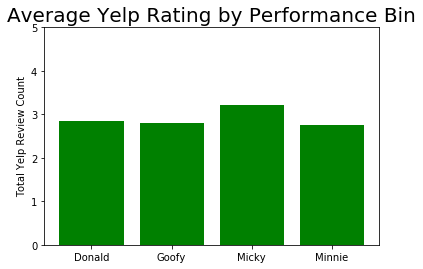

In [14]:
avg_rating = p2_yelp_census.groupby("Bins")["Rating"].mean()
total_review_count = p2_yelp_census.groupby("Bins")["Review Count"].sum()

bins = ["Donald","Goofy","Micky","Minnie"]

plt.bar(bins, avg_rating, color="green", align="center")

plt.title("Average Yelp Rating by Performance Bin", size=20)
plt.savefig("yelp_average_rating_by_performance_bin.png")
plt.ylabel("Total Yelp Review Count")
plt.ylim(0,5)

Text(24.125,0.5,'Total Yelp Review Count')

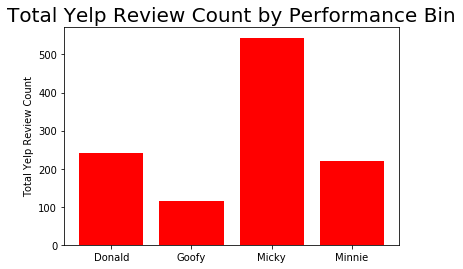

In [15]:
avg_rating

plt.bar(bins, total_review_count, color="r", align="center")

plt.title(f"Total Yelp Review Count by Performance Bin", size=20)
plt.savefig("Yelp_total_review_count_by_performance_bin.png")
plt.ylabel("Total Yelp Review Count")

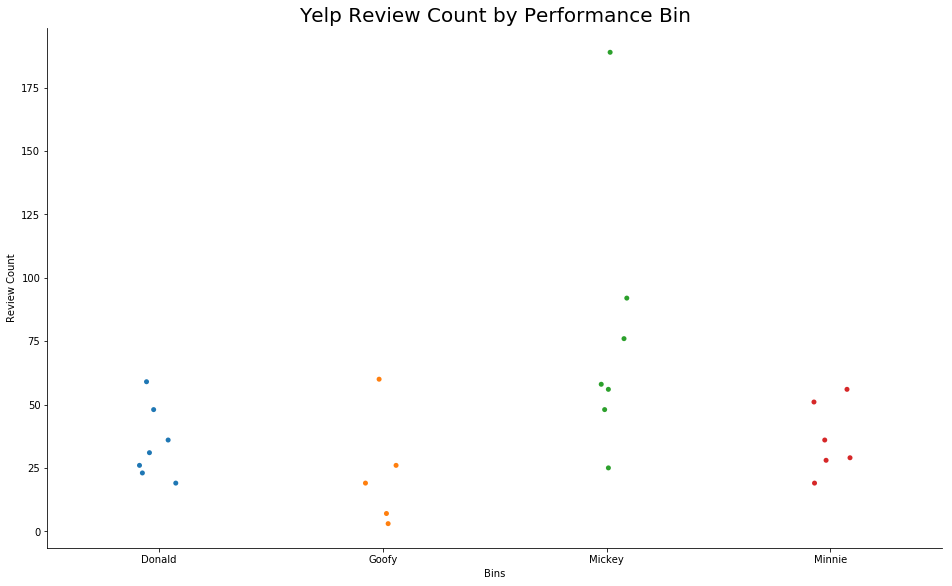

In [16]:
sns.catplot(x="Bins", y="Review Count", data=p2_yelp_census, hue="Bins", height=8, aspect=20/12)
plt.title('Yelp Review Count by Performance Bin', size=20)
plt.savefig("Yelp_review_count_by_performance_bin.png")
plt.show()

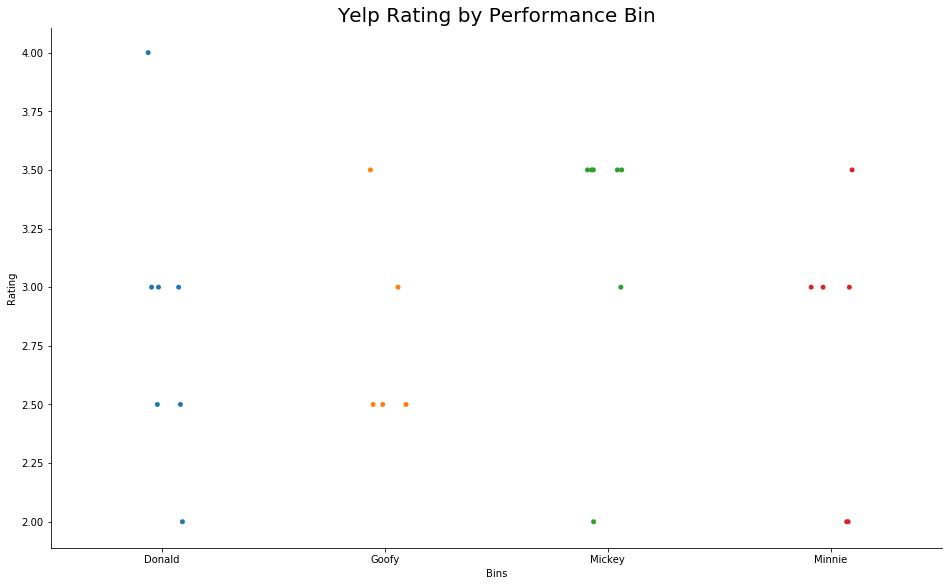

In [17]:
sns.catplot(x="Bins", y="Rating", data=p2_yelp_census, hue="Bins", height=8, aspect=20/12)
plt.title('Yelp Rating by Performance Bin', size=20)
plt.savefig("Yelp_rating_by_performance_bin.png")
plt.show()

# Part III: Coupons and New Customers

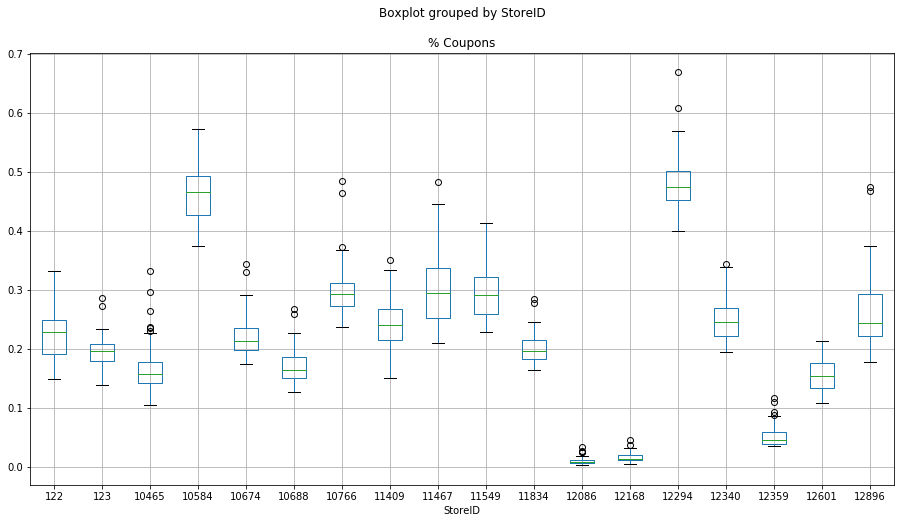

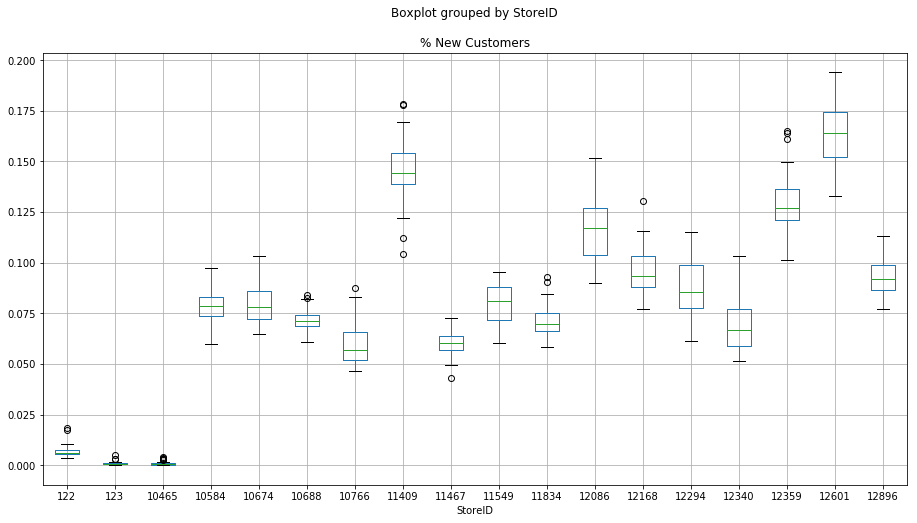

In [18]:
# Analysis to check if there is any correlation between coupons and new customers
# Starting by plotting boxplots by store
analysis_data.boxplot(by="StoreID",column="% Coupons",figsize=(15,8))
plt.savefig("boxplot_coupons.png")
analysis_data.boxplot(by="StoreID",column="% New Customers",figsize=(15,8))
plt.savefig("boxplot_newcustomers.png")
plt.show()

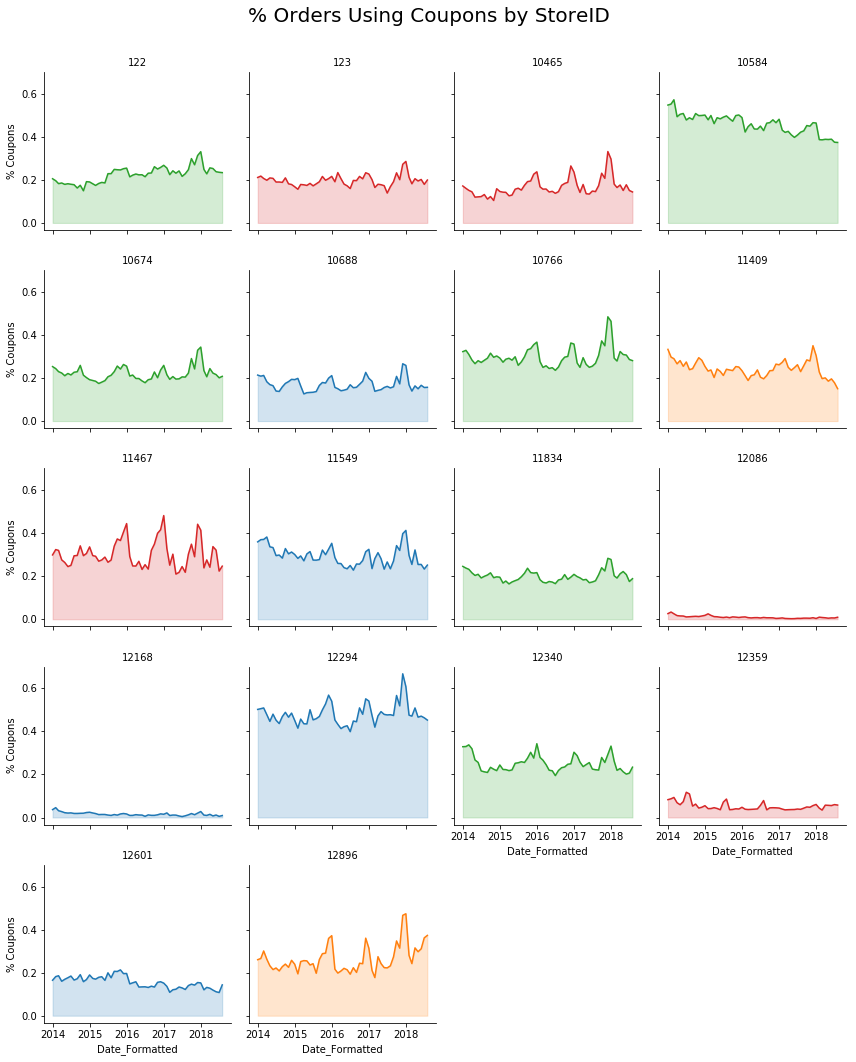

In [19]:
# Create a grid : initialize it
g = sns.FacetGrid(analysis_data, col='StoreID', hue='Bins', col_wrap=4)
 
# Add the line over the area with the plot function
g = g.map(plt.plot, 'Date_Formatted', '% Coupons')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Date_Formatted', '% Coupons', alpha=0.2).set_titles("StoreID")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('% Orders Using Coupons by StoreID', size=20)
 
plt.savefig("pct_coupon_orders_by_store.png")
plt.show()

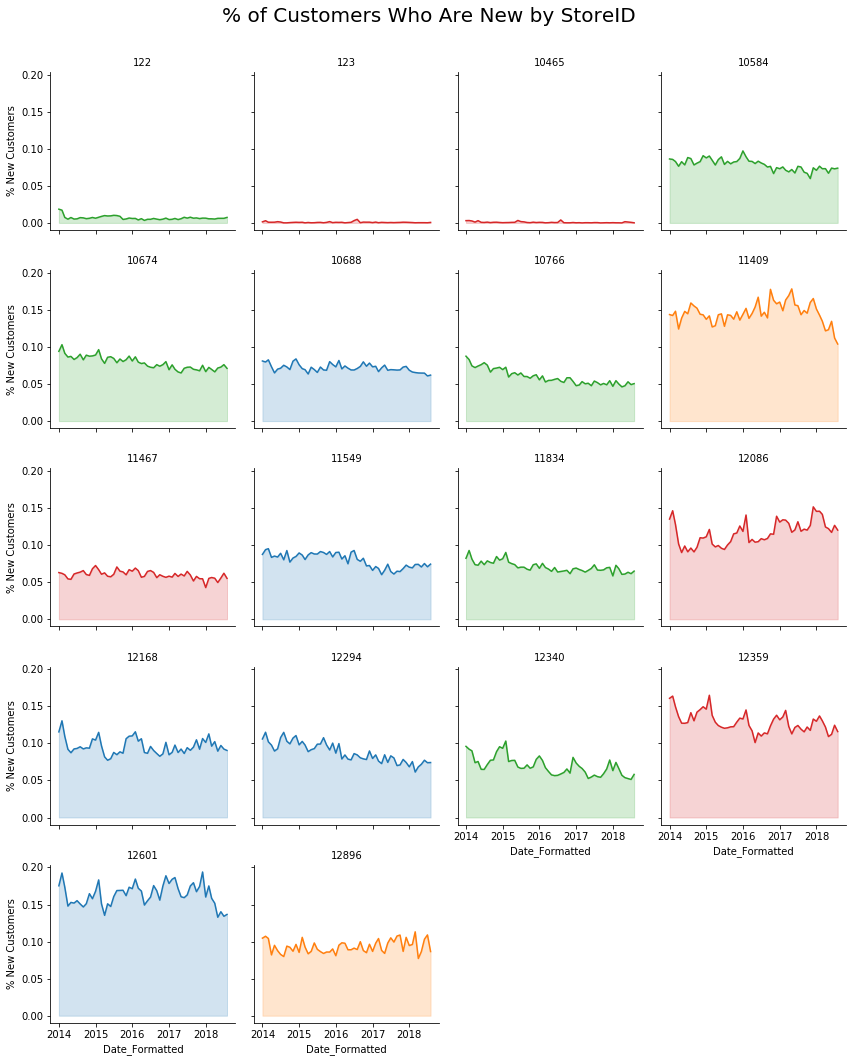

In [20]:
# Create a grid : initialize it
g = sns.FacetGrid(analysis_data, col='StoreID', hue='Bins', col_wrap=4)
 
# Add the line over the area with the plot function
g = g.map(plt.plot, 'Date_Formatted', '% New Customers')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Date_Formatted', '% New Customers', alpha=0.2).set_titles("{col_name} StoreID")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('% of Customers Who Are New by StoreID', size=20)
 
plt.savefig("pct_new_customers_by_store.png")
plt.show()

In [21]:
# Create initial lists to append with correlations for each store and bucket. Also create a list with all disney buckets.
disney_bins = ["Mickey", "Minnie", "Donald", "Goofy"]
corr_stores = []
corr_bins = []

# Calculate the pearson correlation for each store and append to above list
for store in store_selection["StoreID"]:
    auxiliar = pearsonr(analysis_data.loc[analysis_data["StoreID"] == store, "% Coupons"],
                        analysis_data.loc[analysis_data["StoreID"] == store, "% New Customers"])
    corr_stores.append(auxiliar[0])

# Calculate the pearson correlation for each disney bucket and append to above list
for disney_bin in disney_bins:
    auxiliar = pearsonr(analysis_data.loc[analysis_data["Bins"] == disney_bin, "% Coupons"],
                        analysis_data.loc[analysis_data["Bins"] == disney_bin, "% New Customers"])
    corr_bins.append(auxiliar[0])

# Print number of correlations in the lists to check for issues
print("Number of stores with correlation calculated: " + str(len(corr_stores)))
print("Number of Disney buckets with correlation calculated: " + str(len(corr_bins)))

Number of stores with correlation calculated: 18
Number of Disney buckets with correlation calculated: 4


In [22]:
pearsonr(analysis_data["% Coupons"],analysis_data["% New Customers"])

(-0.16568982356547984, 1.237022177671558e-07)

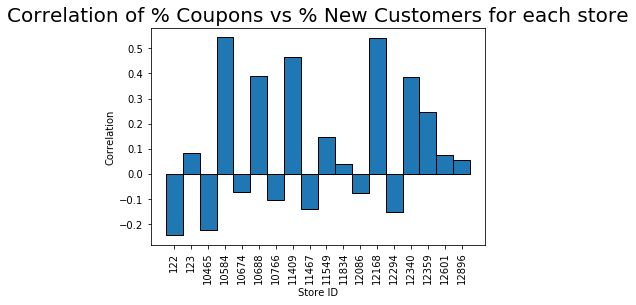

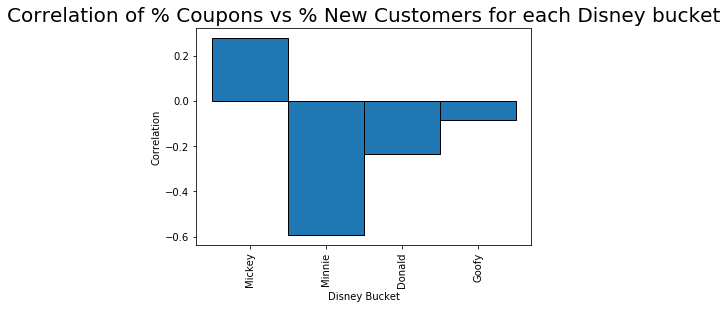

In [23]:
# Plot a bar chart with the correlation for each store
y_pos = np.arange(len(store_selection["StoreID"]))
plt.bar(y_pos, corr_stores, edgecolor="black", width=1)
plt.xticks(y_pos, store_selection["StoreID"])
plt.title("Correlation of % Coupons vs % New Customers for each store", size=20)
plt.ylabel("Correlation")
plt.xlabel("Store ID")
plt.xticks(rotation=90)
plt.savefig("barchart_corr_stores.png")
plt.show()

# Plot a bar chart with the correlation for each disney bucket
y_pos = np.arange(len(disney_bins))
plt.bar(y_pos, corr_bins, edgecolor="black", width=1)
plt.xticks(y_pos, disney_bins)
plt.title("Correlation of % Coupons vs % New Customers for each Disney bucket", size=20)
plt.ylabel("Correlation")
plt.xlabel("Disney Bucket")
plt.xticks(rotation=90)
plt.savefig("barchart_corr_buckets.png")
plt.show()

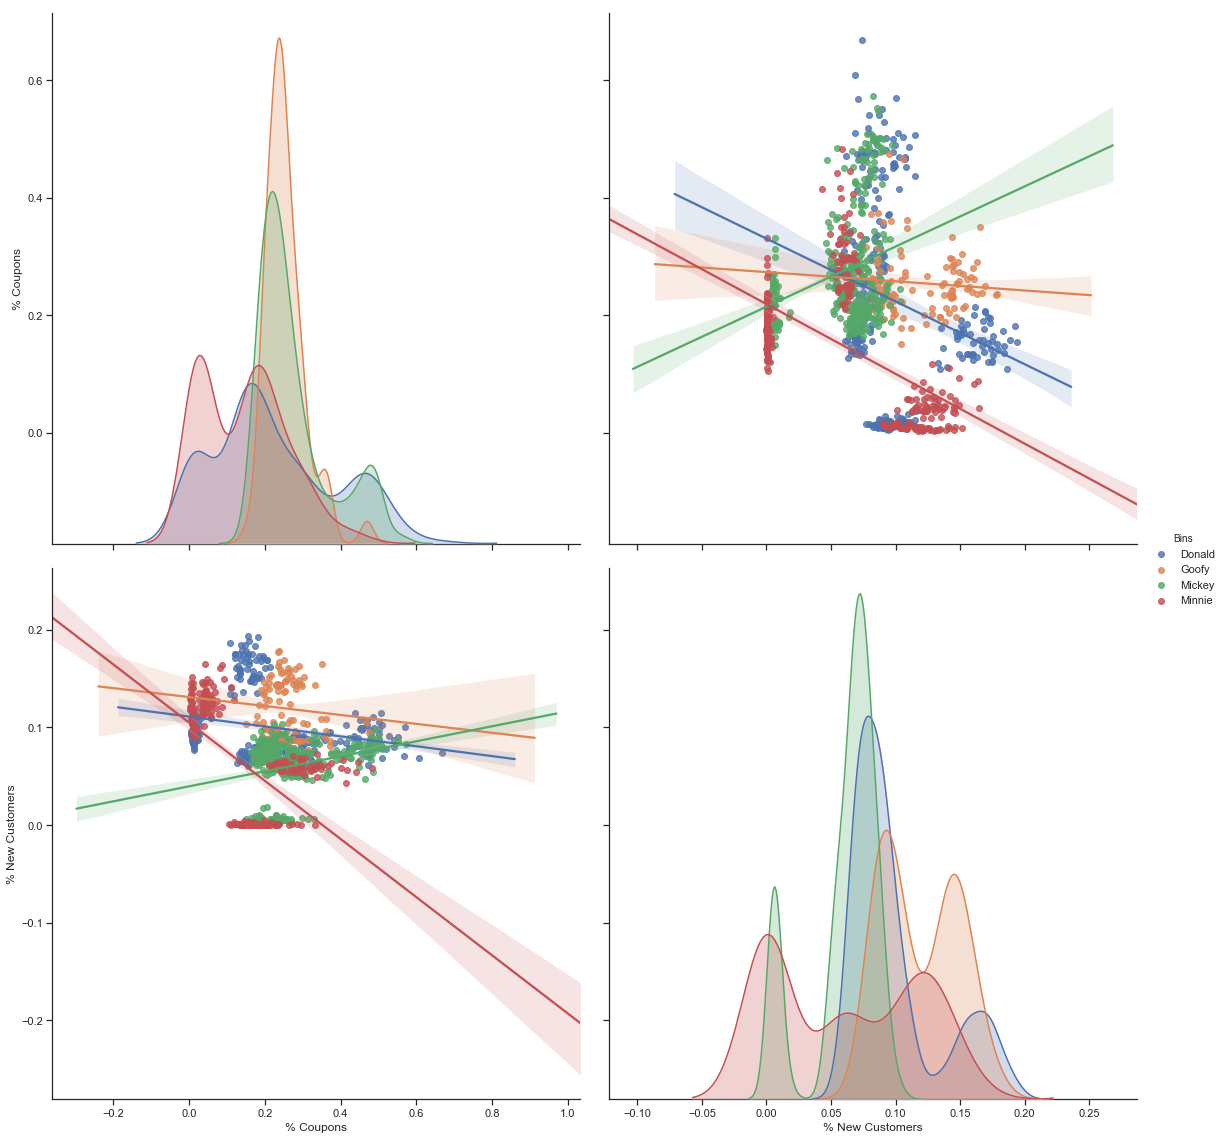

In [24]:
# Visualize distribution and scatterplot by Disney bucket to try to validate above numbers
sns.set(style="ticks", color_codes=True)
sns.pairplot(analysis_data[["Bins", "% Coupons", "% New Customers"]],
             vars=["% Coupons", "% New Customers"],
             hue="Bins",
             diag_kind="kde",
             diag_kws=dict(shade=True), kind="reg",
             height=8
)
plt.savefig("pairplot_buckets.png")
plt.show()

# Part IV - Census API and Store 12340

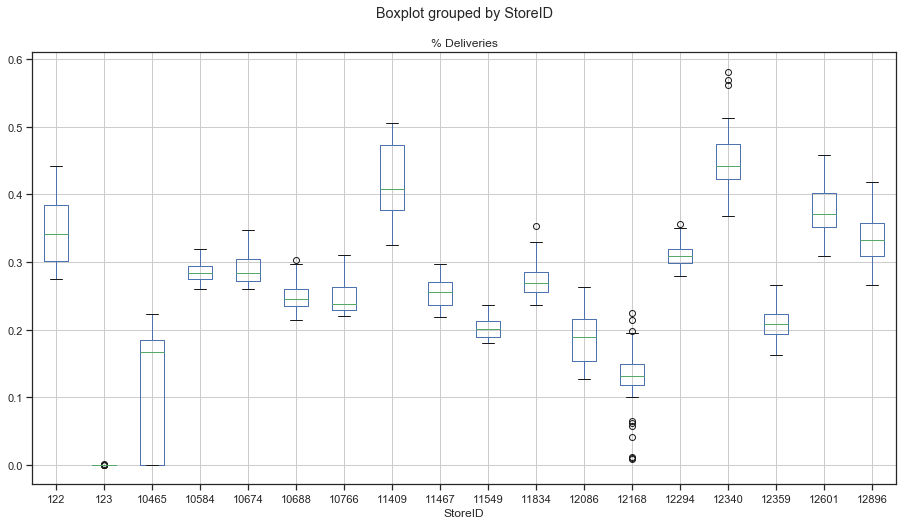

In [25]:
# Question: convenience/access is an important factor for millennials. Does Store 12340 deliver proportionally more than other stores?
# Result: Yes - it is the highest with almost 50% of orders as deliveries
analysis_data.boxplot(by="StoreID",column="% Deliveries",figsize=(15,8))
plt.show()

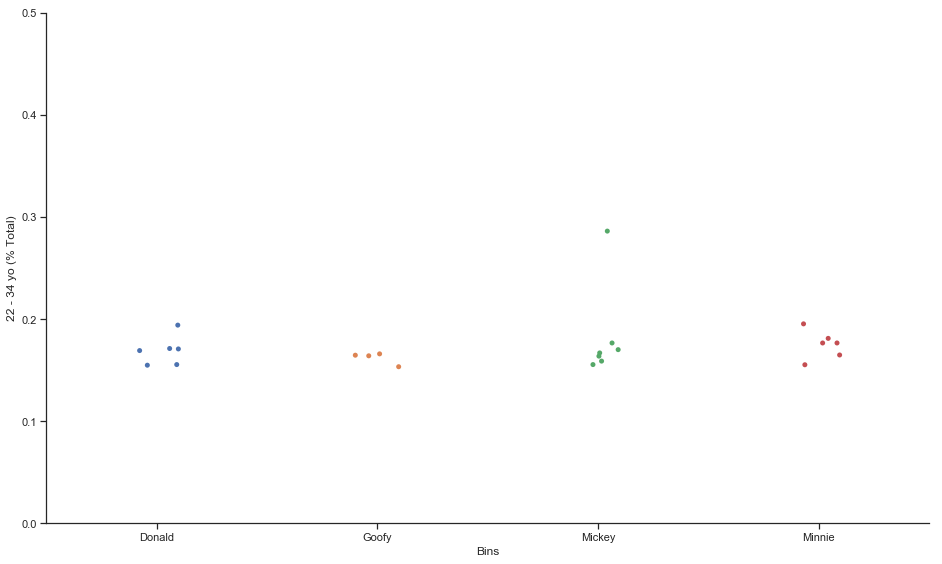

In [26]:
# Explore: millennials - one store (12340) serves notably more  
sns.catplot(x="Bins", y="22 - 34 yo (% Total)", data=p2_yelp_census, hue="Bins", height=8, aspect=20/12)
plt.ylim(0,.50)
plt.savefig("pct_millennial_by_store.png")
plt.show()

In [27]:
store_final_12340 = store_final[store_final["StoreID"] == 12340].reset_index(drop=True)

# Create a new dataframe grouping information at store and month level
analysis_data_12340 = pd.DataFrame({
    "Total Grubhub Deliveries" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["GrubhubDeliveryCt"].sum(),
    "Total Deliveries (no Grubhub)" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["DeliveryCount"].sum(),
    "Total Pickups" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["PickupCount"].sum(),
    "Total Walkins" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["WalkinCount"].sum(),
    "Total Dineins" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["DineinCount"].sum(),
    "Average Deliveries" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["DeliveryCount"].mean(),
    "Total Coupons" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["CouponsRedeemed"].sum(),
    "Average Coupons" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["CouponsRedeemed"].mean(),
    "Total Customers" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["TotCustbyDay"].sum(),
    "Total New Customers" : store_final_12340.groupby(["Bins", "StoreID","Year Month","Year"])["NewCust"].sum()
}).reset_index()

# Add extra columns to the dataframe, using above summaries as input
analysis_data_12340["Total Transactions"] = analysis_data_12340["Total Grubhub Deliveries"] + analysis_data_12340["Total Deliveries (no Grubhub)"] + analysis_data_12340["Total Pickups"] + analysis_data_12340["Total Walkins"] + analysis_data_12340["Total Dineins"]
analysis_data_12340["Total Deliveries (including Grubhub)"] = analysis_data_12340["Total Grubhub Deliveries"] + analysis_data_12340["Total Deliveries (no Grubhub)"]
analysis_data_12340["% Deliveries"] = analysis_data_12340["Total Deliveries (including Grubhub)"] / analysis_data_12340["Total Transactions"]
analysis_data_12340["Grubhub (% of Total Deliveries)"] = analysis_data_12340["Total Grubhub Deliveries"]/ analysis_data_12340["Total Deliveries (including Grubhub)"] 
analysis_data_12340["% Pickups"] = analysis_data_12340["Total Pickups"] / analysis_data_12340["Total Transactions"]
analysis_data_12340["% Walkins"] = analysis_data_12340["Total Walkins"] / analysis_data_12340["Total Transactions"]
analysis_data_12340["% Dineins"] = analysis_data_12340["Total Dineins"] / analysis_data_12340["Total Transactions"]
analysis_data_12340["% Coupons"] = analysis_data_12340["Total Coupons"] / analysis_data_12340["Total Transactions"]
analysis_data_12340["% New Customers"] = analysis_data_12340["Total New Customers"] / analysis_data_12340["Total Customers"]
analysis_data_12340.head()

#https://www.tutorialspoint.com/How-to-convert-Python-date-string-mm-dd-yyyy-to-datetime
year_month_series = analysis_data_12340['Year Month']
date_fmt_series = []

for year_month in year_month_series:

    date_str = str(year_month)
    format_str = '%Y%m' # The format
    datetime_obj = datetime.datetime.strptime(date_str, format_str)
    date_fmt_series.append(datetime_obj.date())
    
analysis_data_12340['Date_Formatted'] = date_fmt_series
analysis_data_12340.head()

,Bins,StoreID,Year Month,Year,Total Grubhub Deliveries,Total Deliveries (no Grubhub),Total Pickups,Total Walkins,Total Dineins,Average Deliveries,...,Total Transactions,Total Deliveries (including Grubhub),% Deliveries,Grubhub (% of Total Deliveries),% Pickups,% Walkins,% Dineins,% Coupons,% New Customers,Date_Formatted
0,Mickey,12340,201401,2014,173,3451,1463,828,311,111.322581,...,6226,3624,0.582075,0.047737,0.234982,0.132991,0.049952,0.320109,0.095984,2014-01-01
1,Mickey,12340,201402,2014,150,3481,1526,836,353,124.321429,...,6346,3631,0.572171,0.041311,0.240466,0.131737,0.055626,0.322408,0.092178,2014-02-01
2,Mickey,12340,201403,2014,166,3542,1487,858,205,114.258065,...,6258,3708,0.592522,0.044768,0.237616,0.137105,0.032758,0.329019,0.089962,2014-03-01
3,Mickey,12340,201404,2014,183,3027,1481,977,410,104.379310,...,6078,3210,0.528134,0.057009,0.243666,0.160744,0.067456,0.310135,0.073958,2014-04-01
4,Mickey,12340,201405,2014,167,3134,1517,977,756,101.096774,...,6551,3301,0.503893,0.050591,0.231568,0.149138,0.115402,0.260724,0.075593,2014-05-01


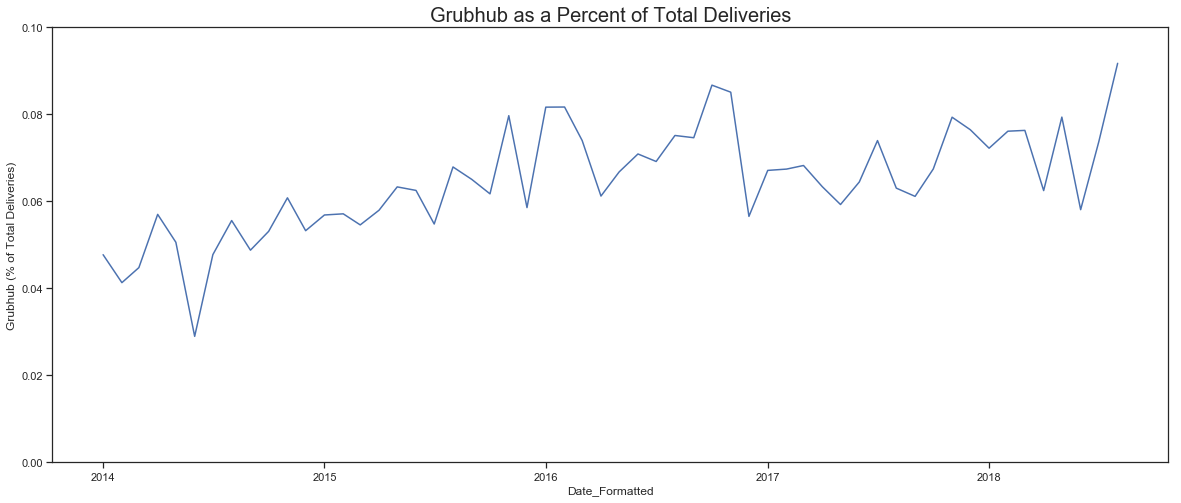

In [28]:
plt.figure(figsize=(20,8))
plt.ylim(0,.10)
plt.title("Grubhub as a Percent of Total Deliveries", size=20)
sns.lineplot(x=analysis_data_12340["Date_Formatted"], y= analysis_data_12340["Grubhub (% of Total Deliveries)"])
plt.savefig("pct_grubhub_of_deliveries_store12340.png")
plt.show()